In [8]:
# Cell 1: Imports & Config

import os, random, shutil, glob, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dataset paths
RAW_DIR  = "dataset_full"   # unzipped dataset (plastic/ organic/ metal)
BASE_DIR = "dataset"        # output folder for train/val/test

CLASSES = ["plastic", "organic", "metal"]

# Split ratios
TRAIN_R, VAL_R, TEST_R = 0.7, 0.2, 0.1

# Training config
IMG_SIZE   = (128, 128)
BATCH_SIZE = 32
EPOCHS     = 50


In [9]:
# Cell 2: Split dataset 70/20/10

def safe_mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p, exist_ok=True)

def split_dataset():
    print("📦 Splitting dataset...")
    for split in ["train", "val", "test"]:
        for cls in CLASSES:
            safe_mkdir(os.path.join(BASE_DIR, split, cls))

    for cls in CLASSES:
        src = os.path.join(RAW_DIR, cls)
        images = glob.glob(os.path.join(src, "*"))
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_R)
        n_val   = int(n * VAL_R)
        n_test  = n - n_train - n_val

        train_files = images[:n_train]
        val_files   = images[n_train:n_train+n_val]
        test_files  = images[n_train+n_val:]

        for f in train_files:
            shutil.copy(f, os.path.join(BASE_DIR, "train", cls))
        for f in val_files:
            shutil.copy(f, os.path.join(BASE_DIR, "val", cls))
        for f in test_files:
            shutil.copy(f, os.path.join(BASE_DIR, "test", cls))

        print(f"{cls:7s}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

split_dataset()
print("✅ Done splitting")


📦 Splitting dataset...
plastic: 605 train, 173 val, 87 test
organic: 689 train, 197 val, 99 test
metal  : 538 train, 153 val, 78 test
✅ Done splitting


In [10]:
# Cell 3: Data Generators

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True
)
eval_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)
val_data = eval_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_data = eval_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_indices = train_data.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
print("Class indices:", class_indices)


Found 1832 images belonging to 3 classes.
Found 523 images belonging to 3 classes.
Found 264 images belonging to 3 classes.
Class indices: {'metal': 0, 'organic': 1, 'plastic': 2}


In [11]:
# Cell 4: Model

def build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=len(CLASSES)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_model()
model.summary()


/Users/yasiruchamuditha/Me/work/vision/PythonDataScience2/ObjectDetection1/objectdetection/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,659 (8.36 MB)

 Trainable params: 2,190,659 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Cell 5: Train Model

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.8654 - loss: 0.3388 - val_accuracy: 0.8470 - val_loss: 0.3857 - learning_rate: 2.5000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.8609 - loss: 0.3263 - val_accuracy: 0.8528 - val_loss: 0.3688 - learning_rate: 2.5000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.8709 - loss: 0.3083 - val_accuracy: 0.8337 - val_loss: 0.3961 - learning_rate: 2.5000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.8826 - loss: 0.3112 - val_accuracy: 0.8566 - val_loss: 0.3686 - learning_rate: 2.5000e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.8916 - loss: 0.2690 - val_accuracy: 0.8394 - val_loss: 0.3736 - learning_rate: 2.5000e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.8742 - loss: 0.2919 - val_accuracy: 0.8470 - val_loss: 0.3692 - learning_rate: 2.5000e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - acc

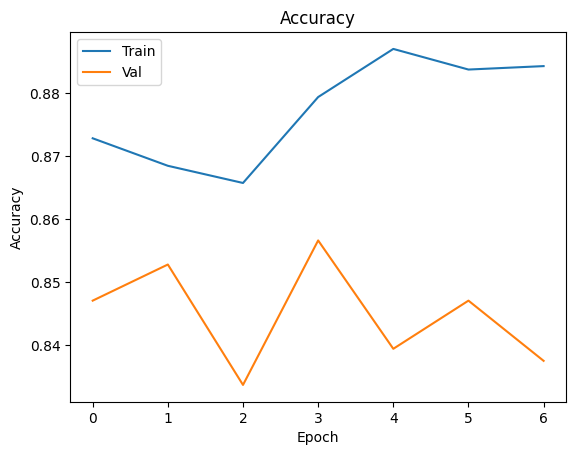

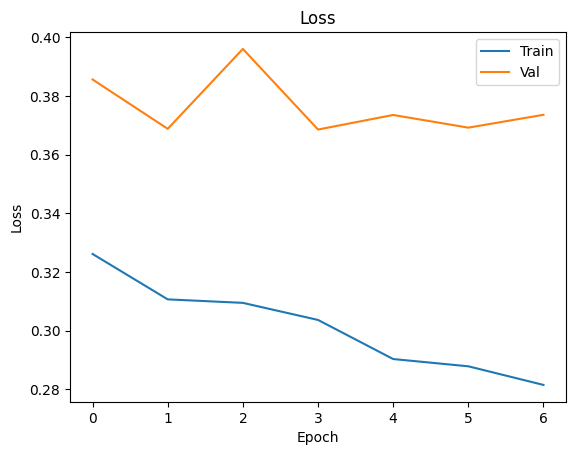

In [14]:
# Cell 6: Plot Training Curves

def plot_curves(history):
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()
    plt.show()

plot_curves(history)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

       metal       0.77      0.78      0.78        78
     organic       0.95      0.91      0.93        99
     plastic       0.82      0.85      0.84        87

    accuracy                           0.85       264
   macro avg       0.85      0.85      0.85       264
weighted avg       0.85      0.85      0.85       264



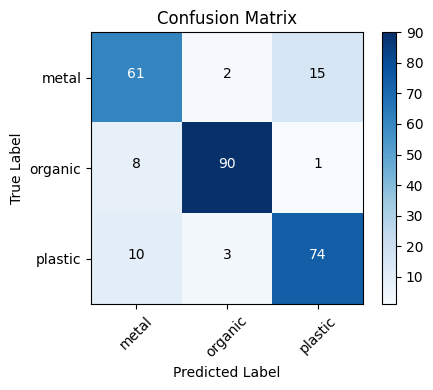

In [15]:
# Cell 7: Evaluate

steps = int(np.ceil(test_data.samples / test_data.batch_size))
probs = model.predict(test_data, steps=steps, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = test_data.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(idx_to_class))]))

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", ha="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True Label"); plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, [idx_to_class[i] for i in range(len(idx_to_class))])


In [16]:
# Cell 8: Save Model

model.save("garbage_classifier.h5")
with open("class_indices.txt", "w") as f:
    for k, v in class_indices.items():
        f.write(f"{k},{v}\n")

print("✅ Saved model and class_indices.txt")


✅ Saved model and class_indices.txt
